## Import Images

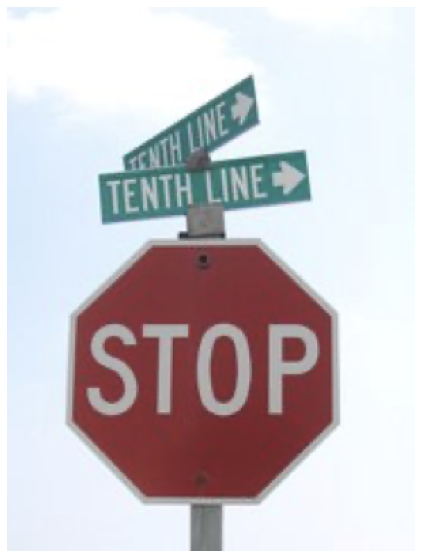

In [1]:
#!/bin/python3

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# First 51 imgs are semaphores
def importImage(no):
    return cv.imread('dataset/images/road' + str(no) + '.png', cv.IMREAD_COLOR)

def displayImage(image, title=""):
    if (len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

displayImage(importImage(52))

## Export XML

In [2]:
import xml.etree.ElementTree as ET

df = pd.DataFrame(columns=["type"])

for i in range(0, 877):
    with open(f"dataset/annotations/road{i}.xml") as xml:
        tree = ET.parse(xml)
        root = tree.getroot()
        
        objects = root.findall("object")
        types = []
        for object in objects:
            types.append(object.find("name").text)

        df.loc[i] = ([types])

df.to_csv("dataset/signs.csv", index=False)

## Import XML

In [3]:
signs = pd.read_csv("dataset/signs.csv")

def typeToList(x):
    x["type"] = x["type"].replace("[", "")
    x["type"] = x["type"].replace("]", "")
    x["type"] = x["type"].replace("'", "")
    x["type"] = x["type"].strip()
    x["type"] = x["type"].split(", ")
    return x["type"]

signs["type"] = signs.apply(typeToList, axis=1)

def filterType(types):
    # Types needs to be a list
    def filter(x):
        return len(set(x["type"]) & set(types)) != 0

    return signs[signs.apply(filter, axis=1) == True]

filterType(["speedlimit"])

,type
100,[speedlimit]
101,[speedlimit]
102,[speedlimit]
103,[speedlimit]
104,[speedlimit]
...,...
871,[speedlimit]
872,"[speedlimit, stop]"
873,"[speedlimit, speedlimit, stop]"
874,"[speedlimit, speedlimit, stop]"


## Segmentação em áreas de interesse
Nesta secção iremos delimitar quais as áreas em que estamos interessados em analisar. Estas regiões correspondem às que contêm os sinais. Para isso iremos usar o colorspace HSV para filtrar as cores de interesse: **azul** e **vermelho**


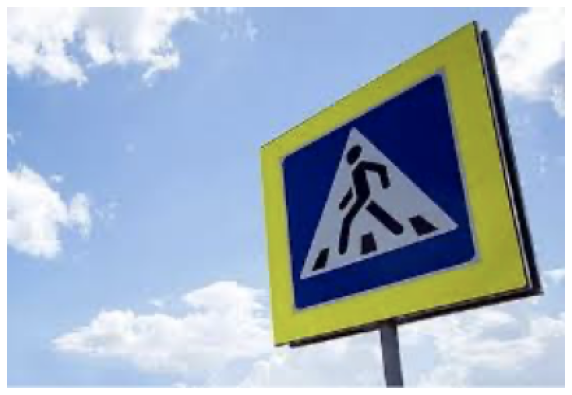

In [4]:
imgId = filterType(["stop"]).index[2]
imgId = 134
img = importImage(imgId)
#speedLimit = cv.imread('dataset/images/test.png')
displayImage(img)

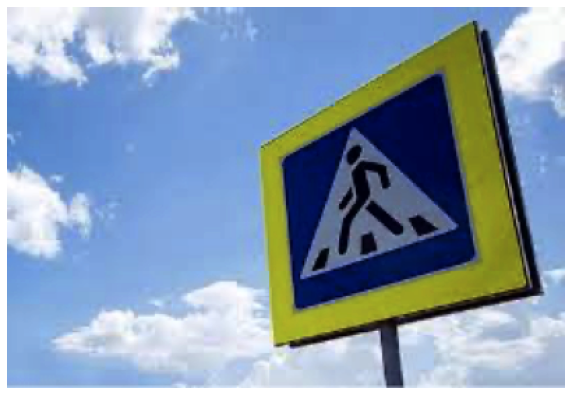

In [5]:
def applyCLAHE(img):
    clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h,s,v = cv.split(hsv)
    s = clahe.apply(s)
    v = clahe.apply(v)
    img = cv.merge([h, s, v])
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

    return img

img = applyCLAHE(img)
displayImage(img)

### Mean Shift
Usado para uniformizar cor da imagem

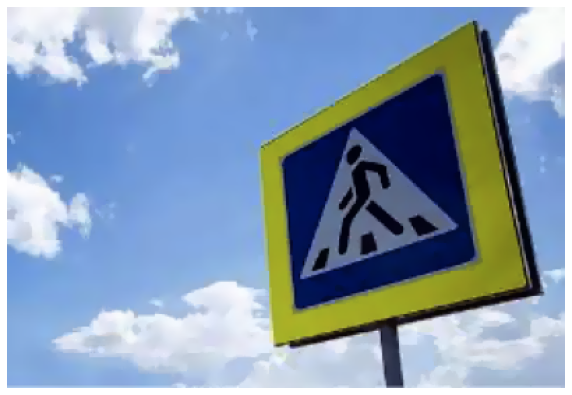

In [6]:
def meanShift(img):
    return cv.pyrMeanShiftFiltering(img, 3, 15, 50)

img = meanShift(img)
displayImage(img)

### Filtro usando HSV
Utilizando as equações em TODO, podemos usar um threshold para selecionar apenas a regiões de forte saturação com fortes intensidades de vermelho ou azul.

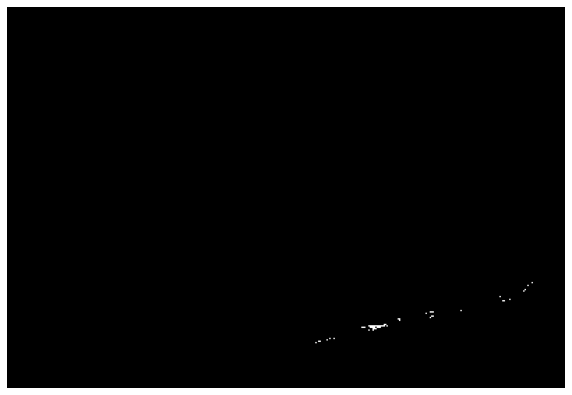

In [7]:
RED = 0
BLUE = 1


def splitColor(img, color):
    def calcScore(H, S, V):
        H = H * 255 / 179
        if color == RED:
            if (H > 210 and H <= 255) or (H >= 0 and H < 10):
                H = 255
            else: 
                H = 0
        elif color == BLUE:
            if (H > 140 and H <= 185):
                H = 255
            else:
                H = 0

        if S < 40:
            H = 0

        if V < 30 or V > 230:
            H = 0

        return H

    height, width = img.shape[0], img.shape[1]
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    b, g, r = cv.split(img)
    h, s, v = cv.split(hsv)
    blank_image_h = np.zeros((height, width), np.uint8)

    # print("SAT:" + str(np.max(s)))
    for i in range(height):
        for j in range(width):
            h_val = calcScore(h[i, j], s[i, j], v[i, j])
            blank_image_h[i, j] = h_val

    return blank_image_h


hs_red = splitColor(img, RED)
hs_blue = splitColor(img, BLUE)

displayImage(hs_red)


BLUE:


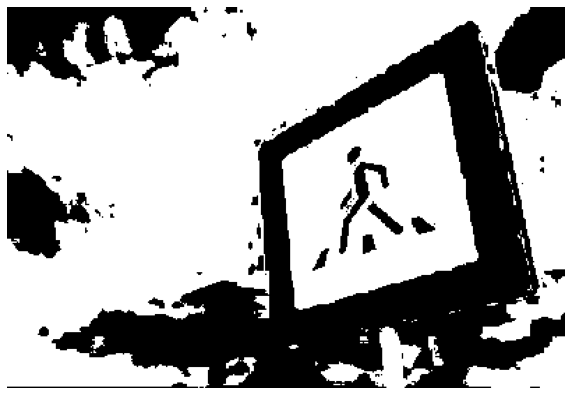

RED:


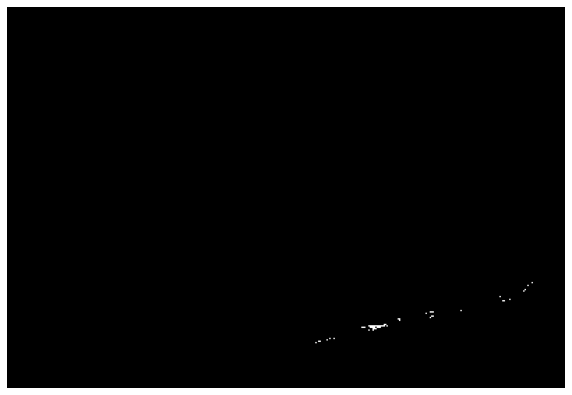

In [8]:
def regionGrow(hs):

    points = []
    hs_r = hs.copy()
    for i in range(0, hs.shape[0], 16):
        for j in range(0, hs.shape[1], 16):
            window = hs[i:i+16, j:j+16]
            whiteCnt = np.sum(window == 255)
            if whiteCnt >= 60:
                stop = False
                for k in range(1, window.shape[0] - 1):
                    for l in range(1, window.shape[1] - 1):
                        if window[k, l] == 255:
                            # hs[i + k, j + l] = 10
                            points.append((i + k, j + l))
                            break
                    else:
                        break

    # displayImage(hs)
    for point in points:
        if hs_r[point] == 254:
            continue
        _, hs_r, m, r = cv.floodFill(hs_r, None, (point[1], point[0]), 254, 17, 15)

    ret, hs_r = cv.threshold(hs_r, 253, 256, cv.THRESH_BINARY)
    return hs_r

def splitImage(img):
    hs_red = splitColor(img, RED)
    hs_blue = splitColor(img, BLUE)

    hs_red = regionGrow(hs_red)
    hs_blue = regionGrow(hs_blue)

    return hs_blue, hs_red


b, r = splitImage(img)

print("BLUE:")
displayImage(b)

print("RED:")
displayImage(r)


### Bounding Boxes - Detecting ROI
Falar um pouco disto
Ainda falta meter um min size nos countours TODO

#### Draw Edges

Apply gaussian blur, then Canny first and then morph close to close neighbouring edges

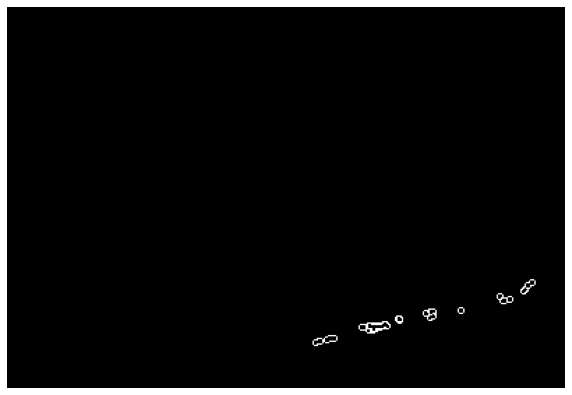

In [9]:
def getEdges(img):
    #img = cv.blur(img, (5, 5))
    img = cv.GaussianBlur(img.copy(), (3, 3), 1)
    #img = cv.morphologyEx(img, cv.MORPH_CLOSE, (5, 5), iterations=3)
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 3, 2)
    #img = cv.Canny(img, 10, 200)
    return img

channel = hs_red

hs_edges = getEdges(channel.copy())
displayImage(hs_edges)

Draw contours and filter them out. Draw a bounding rectangle for each one.

#### Draw Contours and find bounding rectangles

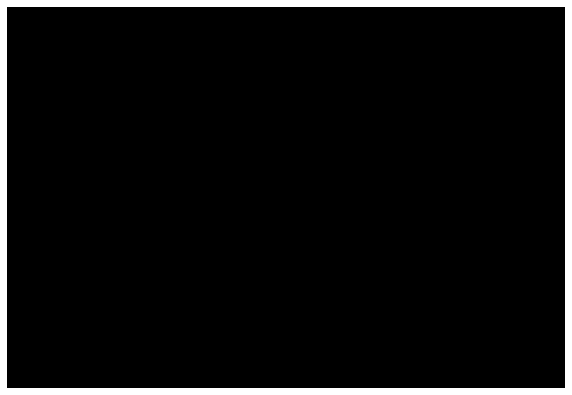

In [10]:
def getAllCountours(img):
    # Returns list of filtered countours => tuple(countour and its bounding rectangle)
    MIN_SIZE = 10
    MIN_COUNT_RECT_RATIO = 0.5
    MIN_ASPECT_RATIO = 0.4

    #ret, thresh = cv.threshold(img,127,255,0)
    #thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
    contours, hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    countours_rects = []
    for i in range(len(contours)):
        cnt = contours[i]
        x,y,w,h = cv.boundingRect(cnt)
        rect = (x, y, w, h)
        # Rect has a minimum size
        if (w < MIN_SIZE or h < MIN_SIZE):
            continue
        # Contour needs to be closed
        contourArea = cv.contourArea(cnt)
        if contourArea <= cv.arcLength(cnt, True):
            continue
        # Percentage contour area needs to be higher than threshold
        contourAreaPerc = contourArea / (w * h)
        if contourAreaPerc <= MIN_COUNT_RECT_RATIO:
            continue
        aspect_ratio = min(w, h) / max(w, h)
        # Aspect ratio needs to be higher than threshold
        if aspect_ratio <= MIN_ASPECT_RATIO:
            continue
        
        countours_rects.append((cnt, rect))
    return countours_rects

#drawing = hs_edges.copy()
drawing = np.zeros((hs_edges.shape[0], hs_edges.shape[1], 1), np.uint8)
countours = getAllCountours(hs_edges.copy())
for cnt, (x, y, w, h) in countours:
    cv.drawContours(drawing, [cnt], 0, 500)
    cv.rectangle(drawing, (x,y), (x + w, y + h), 255, 2)

displayImage(drawing)

Filter out rectangles that are contained inside orders

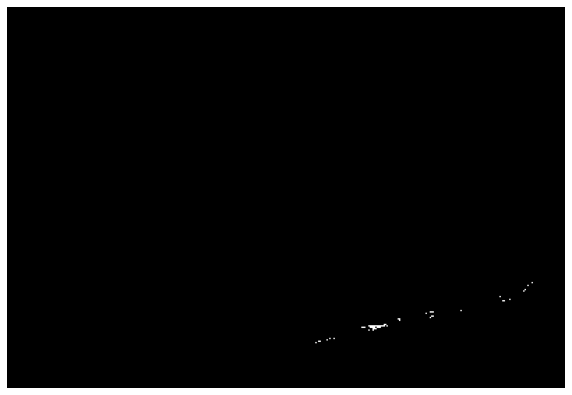

In [11]:
def filterCountours(candidate_countours):
    def isInsideRects(rect, rects):
        def isInside(r1, r2):
            (r1_x1, r1_y1, r1_w, r1_h) = r1
            r1_x2, r1_y2 = r1_x1 + r1_w, r1_y1 + r1_h
            (r2_x1, r2_y1, r2_w, r2_h) = r2
            r2_x2, r2_y2 = r2_x1 + r2_w, r2_y1 + r2_h

            point_dist = lambda x1, y1, x2, y2: np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            p1_d = point_dist(r1_x1, r1_y1, r2_x1, r2_y1)
            p2_d = point_dist(r1_x2, r1_y2, r2_x2, r2_y2)

            return r1_x1 < r2_x1 < r2_x2 < r1_x2 and r1_y1 < r2_y1 < r2_y2 < r1_y2\
                or max(p1_d, p2_d) <= 5 # Are reasonably close
        for r in rects:
            if isInside(r, rect):
                return True
        return False

    # Process bigger area rectanles first
    candidate_countours.sort(key=lambda x: x[1][2] * x[1][3], reverse=True)
    countours, rects = [], []
    for cnt, rect in candidate_countours:
        if not isInsideRects(rect, rects):
            countours.append((cnt, rect))
            rects.append(rect)

    return countours

countours = filterCountours(countours)
drawing = channel.copy()
drawing = drawing / 2
i = 0
for cnt, (x, y, w, h) in countours:
    i += 1
    cv.rectangle(drawing, (x, y), (x + w, y + h), 255, 1)


displayImage(drawing)

## Harris Corner Detection

In [12]:
def addPadding(rect, img, padding):
    # Adds padding to a rect bounding box so that corner detection can be more accurate
    w, h = rect[2], rect[3]
    y1 = max(0, round(rect[1] - h * padding))
    y2 = min(img.shape[0], round(rect[1] + h + h * padding))
    x1 = max(0, round(rect[0] - w * padding))
    x2 = min(img.shape[1], round(rect[0] + w + w * padding))

    return img[y1:y2, x1:x2]

def getCorners(roi):
    neighbourhood = max(roi.shape[0], roi.shape[1]) // 32
    aperture = 1
    free_param = 0.07
    harris = cv.cornerHarris(roi.copy(), 5, 3, 0.05)
    threshold = 0.4

    harris[harris < threshold * harris.max()] = 0
    return harris

#blur = cv.blur(r.copy(),(5,5))
rect = countours[0][1]
roi = addPadding(rect, channel.copy(), 0.15)
corners = getCorners(roi.copy())
displayImage(roi)
displayImage(corners)

IndexError: list index out of range

### Corner Detection - Triangle and square identification

In [ ]:
def cornerIdentification(corners):
    corners = corners.copy()
    w, h= corners.shape[0], corners.shape[1]
    # Identify areas of interest inside the roi
    ratio = 1 / 8
    x_tick = round(h * ratio)
    y_tick = round(w * ratio)
    tl_range = slice(0, 3 * y_tick + 1), slice(0, 3 * x_tick + 1)
    tr_range = slice(0, 3 * y_tick + 1), slice(5 * x_tick, h)
    bl_range = slice(5 * y_tick, w + 1), slice(0, 3 * x_tick + 1)
    br_range = slice(5 * y_tick, w + 1), slice(5 * x_tick, h)

    tc_range = slice(0, 3 * y_tick + 1), slice(3 * x_tick, 5 * x_tick + 1)
    bc_range = slice(5 * y_tick, w + 1), slice(3 * x_tick, 5 * x_tick + 1)

    # Assign values if corners are found inside them
    # displayImage(corners)
    tl, tr, bl, br = 0, 0, 0, 0
    if np.any(corners[tl_range]): tl = 0.25
    if np.any(corners[tr_range]): tr = 0.25
    if np.any(corners[bl_range]): bl = 0.25
    if np.any(corners[br_range]): br = 0.25

    tc, bc = 0, 0
    if np.any(corners[tc_range]): tc = 0.34
    if np.any(corners[bc_range]): bc = 0.34

    square = tl + tr + bl + br
    triangle_up = 1.32 * (bl + br) + tc - 1.1 * (tl + tr)
    triangle_down = 1.32 * (tl + tr) + bc - 1.1 * (bl + br)

    # print(square, triangle_up, triangle_down)
    return square, triangle_up, triangle_down

    
cornerIdentification(corners)

(0.5, 0.395, 0.395)

In [ ]:
def shapeDetection(roi):
    #roi = cv.Canny(roi.copy(), 10, 200)
    # roi = cv.adaptiveThreshold(roi.copy(),255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,3,2)
    # displayImage(roi)
    # roi = cv.GaussianBlur(roi,(9,9),1)
    _,roi = cv.threshold(roi,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    kernel = np.ones((3))
    roi = cv.dilate(roi.copy(), kernel, iterations=2)
    # displayImage(roi)

    cnts = getAllCountours(roi)
    cnts = filterCountours(cnts)
    if len(cnts) == 0:
        return "unidentified"

    c = cnts[0][0] # Get the first filtered contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.018 * peri, True)

    # displayImage(roi)
    if len(approx) == 3:
        return "triangle"
    elif len(approx) == 4:
        return "rectangle"

    hull = cv.convexHull(c)
    peri = cv.arcLength(hull, True)
    area = cv.contourArea(hull)
    approx_circle = cv.approxPolyDP(hull, 0.013 * peri, True)
    circularity = (4 * np.pi * area) / (peri ** 2)
    # print("Circ: " + str(circularity) + " " + str(len(approx_circle)))

    if circularity < 0.7:
        return "unindentified"

    if circularity < 0.96:
        return "octogon"

    return "circle"


roi = addPadding(rect, channel.copy(), 0.15)
shapeDetection(roi)

'unidentified'

In [ ]:
def getContourColorScore(cnt, img):
    # Create a mask image that contains the contour filled in
    cimg = np.zeros_like(img)
    cv.drawContours(cimg, [cnt], 0, color=255, thickness=-1)

    # Access the image pixels and create a 1D numpy array then add to list
    pts = np.where(cimg == 255)
    p = img[pts[0], pts[1]]
    if len(p) == 0: return 0
    return np.mean(p)

i=0
getContourColorScore(countours[i][0], hs_red.copy()), getContourColorScore(countours[i][0], hs_blue.copy())

IndexError: list index out of range

### Circle Detection

In [ ]:
MIN_RADIUS = 30
def circleIdentificationFRS(roi):
    import frs
    r_w, r_h = roi.shape[0], roi.shape[1]

    frs_res = frs.frst(roi, max(r_w, r_h) // 2, 2, 0, max(r_w, r_h) / 4, "BRIGHT")
    w, h = frs_res.shape[0], frs_res.shape[1]
    dim = max(w, h)
    tick = 1 / 5
    region = slice(round(2 * tick * dim), round(3 * tick * dim)), slice(round(2 * tick * dim), round(3 * tick * dim))

    m = frs_res[region].max()
    avg = np.average(frs_res[region])
    # print("M: ", m, "AVG: ", avg, avg / m)
    # print(frs_res[region])
    #displayImage(frs_res[region])
    #displayImage(frs_res)
    cp = avg / m
    return cp


def circleIdentification(roi): # Octogono => 92% area of circle
    ret, thresh = cv.threshold(roi.copy(),100,200,0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) # TODO
    if (len(contours) == 0):
        return 0

    # for cnt in contours:
        # cv.drawContours(roi, [cnt], 0, 500)
    # displayImage(roi)

    cnt = contours[0]
    (x, y), r = cv.minEnclosingCircle(cnt)
    area_circle = np.pi * r ** 2
    contourArea = cv.contourArea(cnt)

    return contourArea / area_circle

rect = countours[0][1]
# blur = cv.blur(r.copy(),(5,5))
roi = addPadding(rect, channel.copy(), 0.15)
# circleIdentification(roi)

circleIdentification(roi)

IndexError: list index out of range

## Shape detection

In [ ]:
COLOR_THRESHOLD = 0.5
SHAPE_THRESHOLD = 0.4
CIRCLE_THRESHOLD = 0.9

# from enum import Enum
# class Sign(Enum):
#     STOP = 1
#     INFORMATION = 2
#     SPEEDLIMIT = 3
#     WARNING = 4
#     PRIORITY = 5


def classifyContours(b, r, cnts_b, cnts_r, printProbs=False):
    def classifyRed(r, rect, c, printProbs=False):
        red = addPadding(rect, r, 0.15)
        corners_r = getCorners(red)
        sq_r, t_up_r, t_down_r = cornerIdentification(corners_r)
        circle_r = circleIdentification(red)
        shape_max = max(sq_r, t_up_r, t_down_r, circle_r)
        red_pred = shapeDetection(red)
        if printProbs:
            print("Red is " + red_pred + " - Square: ", sq_r, " TriUp: ", t_up_r, " TriDown: ", t_down_r, " Circle: ", circle_r)
            #displayImage(red)

        if red_pred == "triangle" or\
            (red_pred == "unidentified" and (shape_max == t_down_r or shape_max == t_up_r)):

            if (t_up_r > t_down_r):
                return "danger"
            else:
                return "yield"
        if red_pred == "circle" or\
            (red_pred == "unidentified" and shape_max == circle_r):
            return "speedlimit"
        
        if red_pred == "octogon":
            return "stop"

        return "unidentified"

    def classifyBlue(b, rect, c, printProbs=False):
        blue = addPadding(rect, b, 0.15)
        corners_b = getCorners(blue)
        sq_b, t_up_b, t_down_b = cornerIdentification(corners_b)
        circle_b = circleIdentification(blue)
        shape_max = max(sq_b, t_up_b, t_down_b, circle_b)
        blue_pred = shapeDetection(blue)

        if printProbs:
            # displayImage(blue), displayImage(red)
            # print("Scored blue: " + str(blue_score) + " red: " + str(red_score))
            print("Blue is " + blue_pred + " - Square: ", sq_b, " TriUp: ", t_up_b, " TriDown: ", t_down_b, " Circle: ", circle_b)

        if shape_max < SHAPE_THRESHOLD and blue_pred == "unidentified":
            return "unidentified"
            # displayImage(blue)
        if blue_pred == "rectangle" or\
            (blue_pred == "unidentified" and shape_max == sq_b):
            return "crosswalk"
        if blue_pred == "circle" or\
            (blue_pred == "unidentified" and shape_max == circle_b):
            return "mandatory"

        return "unidentified"

    ret = []
    for cnt, rect in cnts_b:
        sign_class = classifyBlue(b, rect, cnt, printProbs)
        if sign_class != "trash":
            ret.append(sign_class)
    for cnt, rect in cnts_r:
        sign_class = classifyRed(r, rect, cnt, printProbs)
        if sign_class != "trash":
            ret.append(sign_class)

    return ret

cnts_b = filterCountours(getAllCountours(hs_blue))
cnts_r = filterCountours(getAllCountours(hs_red))
classifyContours(hs_blue, hs_red, cnts_b, cnts_r, True)

Blue is rectangle - Square:  1.0  TriUp:  0.44999999999999996  TriDown:  0.44999999999999996  Circle:  0.4316662220819116
Blue is unindentified - Square:  0.75  TriUp:  -0.22000000000000003  TriDown:  0.725  Circle:  0.0
Blue is rectangle - Square:  0.75  TriUp:  0.385  TriDown:  -0.22000000000000003  Circle:  0.61028359522725


['crosswalk', 'unidentified', 'crosswalk']

## Create Pipeline
To a function that will be used to test with the entire dataset

In [14]:
def classifyImage(imageNo):
    print("Parsing: " + str(imageNo))
    img = importImage(imageNo)
    # displayImage(img)
    img = applyCLAHE(img)
    img = meanShift(img)
    b, r = splitImage(img)
    def getContours(c):
        hs_edges = getEdges(c)
        countours = getAllCountours(hs_edges)
        countours = filterCountours(countours)
        return countours
    predicts = classifyContours(b, r, getContours(b), getContours(r), countours)
    return predicts

#classifyImage(102)
classifyImage(filterType(["stop"]).index[7])

Parsing: 58


NameError: name 'classifyContours' is not defined

## Evaluation

In [13]:
sign_types = ["speedlimit", "crosswalk", "stop"]
sign_accs = [sign_t + "_acc" for sign_t in sign_types]
df = pd.DataFrame(columns = [sign_accs + ["recall", "predicted", "expected"]])
def accuracy(predictions, expected):
    def createDictCount(x):
        return {item:x.count(item) for item in x}

    preds_d = createDictCount(predictions)
    expected_d = createDictCount(expected)
    hits, guesses = 0, 0
    accs = []
    for t in sign_types:
        if t in expected_d:
            if t in preds_d: # Put accuracy
                accs.append(min(preds_d[t], expected_d[t]) / expected_d[t])
                hits += min(preds_d[t], expected_d[t])
                guesses += preds_d[t]
            else: # No prediction => Accuracy 0
                accs.append(0)
        else: # No type expected
            accs.append(None)

    recall = hits / guesses if guesses != 0 else 0
    return preds_d, expected_d, recall, accs

good = [52, 137, 152, 134, 94, 516, 121, 57, 68]
baixa_sat = [637, 715, 411, 390, 317, 303, 382, 337, 335, 74]
shited = [22, 135, 453, 349, 558, 106]

tmp = filterType(["speedlimit"])
#for index, x in tmp.iterrows():
for i in range(52, 877):
    x = signs.loc[i]
    expected = list(filter(lambda x: "trafficlight" not in x, x["type"]))
    if len(expected) == 0: # Ignore images that contain traffic lights
        continue

    predicts = classifyImage(i)
    print(predicts)
    preds_d, expect_d, recall, accs = accuracy(predicts, expected)
    df.loc[i] = accs + [recall, preds_d, expect_d]

df

NameError: name 'classifyImage' is not defined

Export results

In [134]:
#df.to_csv("results.csv")
#df = pd.read_csv("results.csv")
# df

In [217]:
df["stop_acc"].mean(), df["crosswalk_acc"].mean(), df["speedlimit_acc"].mean(), df["recall"].mean()

(stop_acc    0.25
 dtype: float64,
 crosswalk_acc   NaN
 dtype: float64,
 speedlimit_acc    0.214286
 dtype: float64,
 recall    0.3
 dtype: float64)